In [3]:
from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
from pywdf.core.circuit import Circuit
import numpy as np

class RC_HighPass_1st(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.C1 = Capacitor(self.C, self.fs)
        self.R1 = Resistor(self.R)

        self.S1 = SeriesAdaptor(self.C1, self.R1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.R1)

    def set_cutoff(self, fc):
        self.cutoff = fc
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.R1.set_resistance(self.R)

class RC_LowPass_1st(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)

        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs = IdealVoltageSource(self.S1)

        super().__init__(source=self.Vs, root=self.Vs, output=self.C1)

    def set_cutoff(self, fc):
        self.cutoff = fc
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
        self.R1.set_resistance(self.R)

class RCBandPass2ndOrder(Circuit):
    def __init__(self, fs: float, cutoff: float = 1000.0, bandwidth_octaves: float = 1.0):
        self.fs = fs
        self.cutoff = cutoff
        self.bandwidth = bandwidth_octaves
        self.auto_gain = True

        # Crear los 4 filtros individuales
        self.hp1 = RC_HighPass_1st(fs, 1)
        self.hp2 = RC_HighPass_1st(fs, 1)
        self.lp1 = RC_LowPass_1st(fs, 1)
        self.lp2 = RC_LowPass_1st(fs, 1)

        self.set_cutoff_and_bandwidth(cutoff, bandwidth_octaves)

    def __call__(self, x):
        if self.auto_gain:
            x = x * 2.23
        x = self.hp1(x)
        x = self.hp2(x)
        x = self.lp1(x)
        x = self.lp2(x)
        return x

    def get_impulse_response(self, delta_dur=1, amp=1.0):
        d = np.zeros(int(delta_dur * self.fs))
        d[0] = amp
        return self(d)

    def set_cutoff_and_bandwidth(self, cutoff: float, bandwidth_octaves: float):
        self.cutoff = cutoff
        self.bandwidth = bandwidth_octaves
        ratio = 2 ** (bandwidth_octaves / 2)
        hp_cutoff = np.clip(cutoff / ratio, 20.0, self.fs * 0.45)
        lp_cutoff = np.clip(cutoff * ratio, 20.0, self.fs * 0.45)

        self.hp1.set_cutoff(hp_cutoff)
        self.hp2.set_cutoff(hp_cutoff)
        self.lp1.set_cutoff(lp_cutoff)
        self.lp2.set_cutoff(lp_cutoff)


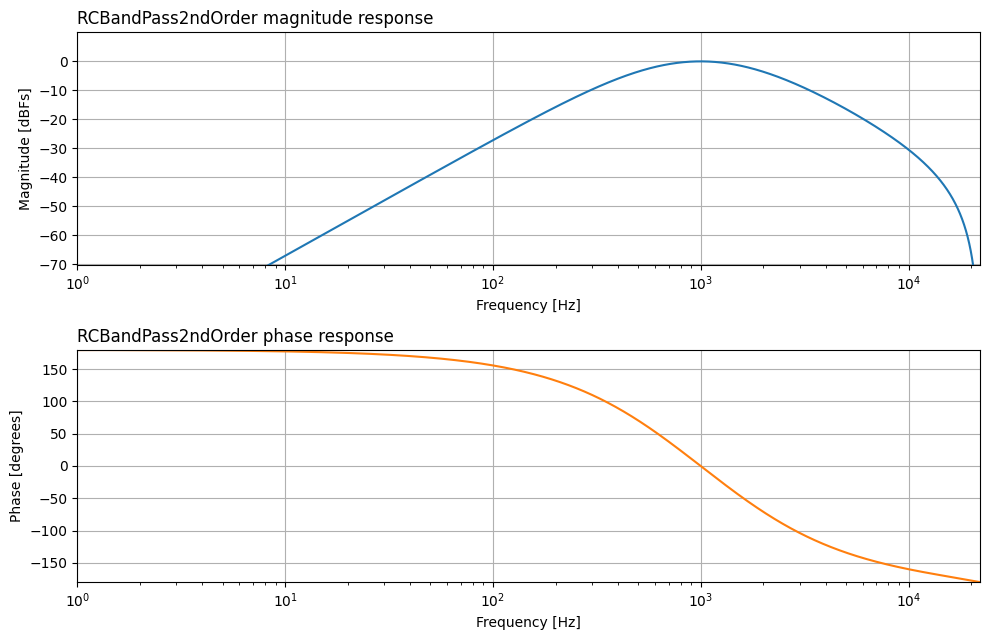

In [ ]:
bp2 = RCBandPass2ndOrder(fs=44100, cutoff=1000, bandwidth_octaves=1.0)
bp2.plot_freqz()
